In [1]:
import BioSimSpace as BSS

In [2]:
node = BSS.Gateway.Node("A node to parameterise a small molecule, run MD and do a conformational analysis.")
node.addAuthor(name="Antonia Mey", email="antonia.mey@ed.ac.uk", affiliation="University of Edinburgh")
node.setLicense("GPLv3")

In [3]:
node.addInput("file", BSS.Gateway.File(help="A molecular input file, e.g. a PDB file."))

node.addInput("forcefield", BSS.Gateway.String(help="The name of the force field to use for parameterisation.",
                                               allowed=BSS.Parameters.forceFields(), default="gaff"))

node.addInput("water", BSS.Gateway.String(help="The name of the water model to use for solvation.",
                                          allowed=BSS.Solvent.waterModels(), default="tip3p"))

node.addInput("box_size", BSS.Gateway.Length(help="The base length of the cubic simulation box.", unit="nanometer"))

node.addInput("ion_conc", BSS.Gateway.Float(help="The ionic concentration in mol/litre.",
                                            minimum=0, maximum=1, default=0))
node.addInput("minimisation_step", BSS.Gateway.Integer(help="The number of minimisation steps", default=1000))
node.addInput("simulation_temp", BSS.Gateway.Temperature(help="Temperature for the production run", default=300, unit="kelvin"))
node.addInput("simulation_length", BSS.Gateway.Time(help="Simulation time for production runs in nanoseconds", default=100, unit="nanosecond"))
node.addOutput("system", BSS.Gateway.FileSet(help="Outputfiles to be used with a NPT equilibration and production simulation"))

In [4]:
node.showControls()

Box(children=(Box(children=(Box(children=(Label(value='file: A molecular input file, e.g. a PDB file.'), FileU…

Uploaded '2-cyclopentanylindole.mol2' (2.97 kB)


In [5]:
## Parmetrisation

In [5]:
system = BSS.IO.readMolecules(node.getInput("file"))
molecule = system[0]
molecule = BSS.Parameters.parameterise(molecule, node.getInput("forcefield")).getMolecule()
system = BSS.Solvent.solvate(node.getInput("water"), molecule=molecule,
                                                     box=3 * [node.getInput("box_size")],
                                                     ion_conc=node.getInput("ion_conc"))

In [6]:
## Minimisation

In [7]:
protocol = BSS.Protocol.Minimisation(node.getInput("minimisation_step"))
process = BSS.MD.run(system, protocol, name="minimise")

In [11]:
process.isRunning()

False

In [12]:
min_syst = process.getSystem()

In [13]:
## NVT Heating

In [14]:
protocol = BSS.Protocol.Equilibration(timestep=1.0*BSS.Units.Time.femtosecond, temperature_start=100*BSS.Units.Temperature.kelvin, temperature_end=node.getInput("simulation_temp"))
process = BSS.MD.run(min_syst, protocol, name="equilibrate")

In [21]:
print(process.getTime(), process.getTemperature(), process.getTotalEnergy())

0.2000 ns 298.6200 K -7.1298e+04 kJ/mol


In [22]:
process.exe()

'/home/ppxasjsm/Software/gromacs/bin/gmx'

In [23]:
system_equib = process.getSystem()

In [ ]:
## NPT equilibration

In [24]:
protocol = BSS.Protocol.Equilibration(temperature=node.getInput("simulation_temp"), ensemble='NPT',runtime=0.5*BSS.Units.Time.nanosecond)
process = BSS.MD.run(system_equib, protocol, name="npt_equilibrate")

In [28]:
process.isRunning()

False

/home/ppxasjsm/Projects/git/BioSimSpace/python/BioSimSpace/Notebook/_plot.py:213: UserWarning: Mismatch in list sizes: len(x) = 2170, len(y) = 2171
  % (len(x), len(y)))


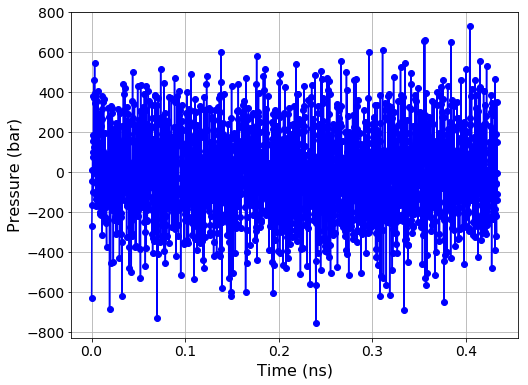

In [27]:
# Generate a plot of time vs temperature.
plot1 = BSS.Notebook.plot(process.getTime(time_series=True),
    process.getPressure(time_series=True))


In [29]:
## production

In [30]:
npt_syst = process.getSystem()

In [31]:
protocol = BSS.Protocol.Production(temperature=node.getInput("simulation_temp"), ensemble='NPT',runtime=node.getInput("simulation_length"), restart=True)
process = BSS.MD.run(npt_syst, protocol, name="production")

In [32]:
process.isRunning()

False

In [33]:
traj = process.getTrajectory()

In [38]:
import mdtraj as md
%pylab inline

Populating the interactive namespace from numpy and matplotlib


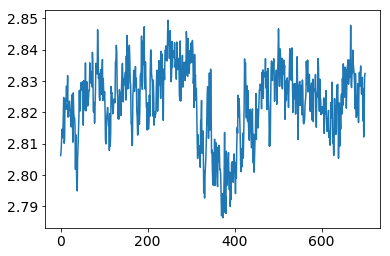

In [42]:
plot(traj.rmsd()[300:])

In [51]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [47]:
data =  np.array(traj.rmsd()[300:]).reshape(-1,1)

In [50]:
db = DBSCAN(eps=0.03, min_samples=10).fit(data)

In [53]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


In [55]:
print(n_noise_)

0


In [62]:
kmeans_model = KMeans(n_clusters=3, random_state=1).fit_predict(data)

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

In [65]:
scatter(data[:,0], c =kmeans_model)

TypeError: scatter() missing 1 required positional argument: 'y'

In [66]:
traj = md.load('input/trajectory_impl.dcd', top='input/alanine-dipeptide-implicit.pdb')

In [68]:
a = md.rmsd(traj, traj[0])

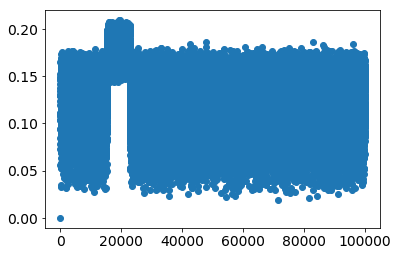

In [73]:
plot(a, lw=0, marker='o')